# Calculate the Isothermal Layer Depth

:::{admonition} Technical info
:class: info
Because the calculation only needs information from one column at a time, we can work on many columns at once. This makes the program run faster. To do this, we use a Python package called Dask, which lets us split the work between multiple workers and run them in parallel. [Dask](https://docs.dask.org/en/stable/10-minutes-to-dask.html) is already included when you install this regional mom6 preprocessing package, so you don’t need to install anything extra.
:::

## Get the data
To calculate the Isothermal Layer Depth (ILD), we need the following data
- sea surface temperature (`tos`)
- potential temperature profile (`thetao`)
- bottom depth at each grid point (`deptho` in the `ocean_static.nc`)

Here we utilize the AWS S3 bucket with the CEFI data to load the data.
We use the `AccessFiles` class from the `mom6_read` module to specify the dataset information and data source. If the connection is successful, the class will return a standard message: `Files are available on S3 (s3://...)`, indicating the S3 link to the dataset.
For a more detail understanding, please go to [CEFI access tutorial](cefi-access-label).

In [1]:
dict_data_info = {
    "region": "northeast_pacific",
    "subdomain": "full_domain",
    "experiment_type": "hindcast",
    "output_frequency": "monthly",
    "grid_type": "raw",
    "release": "r20250509",
    "data_source": "s3"
}
from mom6.mom6_module.mom6_read import AccessFiles
cefi_data_access = AccessFiles(**dict_data_info)

Files are available on S3 (s3://noaa-oar-cefi-regional-mom6-pds/northeast_pacific/full_domain/hindcast/monthly/raw/r20250509)


Once the data `cefi_data_access` object connects to the AWS S3, we can use its `get` method to choose the variable we need for our calculation.

In [2]:
tos_path = cefi_data_access.get(variable='tos')[0] # we only have one file in the list
thetao_path = cefi_data_access.get(variable='thetao')[0]
depth_path = cefi_data_access.get(variable='ocean_static')[0]

In [3]:
tos_path

's3://noaa-oar-cefi-regional-mom6-pds/northeast_pacific/full_domain/hindcast/monthly/raw/r20250509/tos.nep.full.hcast.monthly.raw.r20250509.199301-202412.json'

Each variable path above contains an S3 link to the index file (.json) created by [kerchunk](https://fsspec.github.io/kerchunk/) (a cloud optimized data storage solution similar to Zarr but with the benefit of retaining the original netcdf file). We can now load this data using `Xarray`, a Python package that also comes included when you install this package.

In [4]:
import xarray as xr
s3_storage_options = {
    "remote_options": {"anon": True},
    "remote_protocol": "s3",
    "target_options": {"anon": True},
    "target_protocol": "s3",
}

da_tos = xr.open_dataset(
    tos_path,
    engine="kerchunk",
    chunks={'time': 1, 'yh': 50, 'xh': 50},
    storage_options=s3_storage_options
)['tos'].isel(time=0)

da_thetao = xr.open_dataset(
    thetao_path,
    engine="kerchunk",
    chunks={'time': 1, 'yh': 50, 'xh': 50, 'z_l':-1},
    storage_options=s3_storage_options
)['thetao'].isel(time=0)

da_depth = xr.open_dataset(
    depth_path,
    engine="kerchunk",
    chunks={'time': 1, 'yh': 50, 'xh': 50},
    storage_options=s3_storage_options
)['deptho']


:::{admonition} Techical info
:class: info
The data is now split into chunks as specified when we opened the dataset using the keyword argument `chunks={'time': 1, 'yh': 50, 'xh': 50, 'z_l': -1}`. The setting `'z_l': -1` means that all depth levels for the `thetao` data are kept together in a single chunk. This way, when we run the calculation, all the information for a column is in one place, so the program only needs to work with a single chunk at a time.

:::

Currently, the "data" of each variable is not loaded. But the meta data and the coordinate information has been loaded to the local memory. A quick check below shows how the "data" is store and arranged. 

In [5]:
da_thetao

<xarray.DataArray 'thetao' (z_l: 52, yh: 816, xh: 342)> Size: 58MB
dask.array<getitem, shape=(52, 816, 342), dtype=float32, chunksize=(52, 50, 50), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 1993-01-16T12:00:00
  * xh       (xh) float64 3kB 229.1 229.2 229.3 229.3 ... 254.8 254.9 255.0
  * yh       (yh) float64 7kB 13.86 13.93 14.0 14.07 ... 59.5 59.51 59.52 59.52
  * z_l      (z_l) float64 416B 2.5 7.5 12.5 17.5 ... 5.25e+03 5.75e+03 6.25e+03
Attributes:
    cell_measures:  volume: volcello area: areacello
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

## Calculate ILD
First, we need to load the `mom6_ild` module from `mom6.mom6_module`. Inside this module, there is a class called `IsothermalLayerDepth` that we will use to calculate the Isothermal Layer Depth.


In [6]:
from mom6.mom6_module.mom6_ild import IsothermalLayerDepth

In [16]:
ild_obj = IsothermalLayerDepth(
    da_sst=da_tos,
    da_thetao=da_thetao,
    da_depth=da_thetao['z_l'],
    da_bottom_depth=da_depth,
    ild_temp_offset=0.5,
    depth_dim_name='z_l'
)


The `ild_obj` stores all the information needed to calculate the ILD. One important setting is `ild_temp_offset`, which is the temperature difference from the sea surface temperature. This offset is used to decide the lowest temperature in a water column that is still considered part of the “isothermal layer.” The calculation then finds the depth at which this temperature occurs, which becomes the “depth of the isothermal layer. Since not all depth is named `z_l` like regional MOM6 output, the module make it flexible to choose the depth dimension name.


In [17]:
ds_ild = ild_obj.calculate_ild()

To run the calculation, we will use the `calculate_ild` method. However, at this point we are still not loading the data or doing any real computation. Instead, we’ve created a "calculation plan" (also called a Dask graph) that lists the steps to load the data and perform the ILD calculation. This plan is stored in the `ds_ild` object, which you can inspect by printing `ds_ild`.

In [9]:
ds_ild['ild']

<xarray.DataArray 'ild' (yh: 816, xh: 342)> Size: 2MB
dask.array<transpose, shape=(816, 342), dtype=float64, chunksize=(50, 50), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 1993-01-16T12:00:00
  * xh       (xh) float64 3kB 229.1 229.2 229.3 229.3 ... 254.8 254.9 255.0
  * yh       (yh) float64 7kB 13.86 13.93 14.0 14.07 ... 59.5 59.51 59.52 59.52
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area:mean yh:mean xh:mean time: mean
    long_name:      Isothermal Layer Depth (0.5)
    standard_name:  isothermal_layer_depth
    time_avg_info:  average_T1,average_T2,average_DT
    units:          meters

One can see the dask graph have increased from the 3 graph (`ds_thetao`) to 13 graph (`ds_ild`). This is like what was mentioned above becasue it is now including both loading the data and calculation needed to create the ILD.

### Dask for Parallelization
Here, we use 2 workers so that two chunks (columns) can be calculated at the same time. If your computer has more resources, you can increase the number of workers to speed up the calculation. Keep in mind that the total time also depends on your internet speed and how quickly your machine can access the data stored in the cloud (S3). The fastest results are usually achieved when running on a cloud instance, such as AWS EC2, close to where the data is stored.

A test on the PSL machine showed that using 2 workers took about 15 minutes, while using 64 workers took about 3 minutes. Although it is not 32 times faster, increasing the number of workers still greatly reduces the total computation time.

In [ ]:
# more worker less threads due to GIL of the task involved
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=1)
print(client.dashboard_link)
ds_ild = ds_ild.compute()

http://127.0.0.1:36339/status


:::{admonition} Techical info
:class: info
The HTTP link opens the Dask dashboard, where you can see the processing steps and track the progress. You can learn more about how to use the dashboard to check computational performance here.

:::

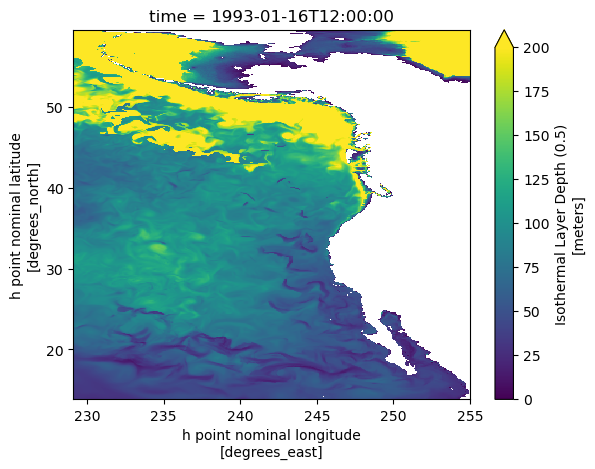

In [11]:
ds_ild.ild.plot(vmin=0, vmax=200, cmap='viridis')

In [ ]:
import s3fs, zarr, fsspec, kerchunk
print('xarry version:', xr.__version__)
print('fsspec version:',fsspec.__version__)
print('zarr version:',zarr.__version__)
print('s3fs version:',s3fs.__version__)
print('kerchunk version:',kerchunk.__version__)


xarry version: 2025.7.1
fsspec version: 2025.7.0
zarr version: 3.1.0
s3fs version: 2025.7.0
kerchunk version: 0.2.9
